
All above the max-y regression line:


,opacity,density,perturb,epsilon,adv_acc,quality,score
0,170,50,False,0.000000,0.000000,0.236778,0.236778
1,150,50,False,0.000000,0.100000,0.300942,0.200942
2,70,50,False,0.000000,0.600000,0.620353,0.020353
3,50,50,False,0.000000,0.700000,0.676527,-0.023473
4,50,60,False,0.000000,0.800000,0.674408,-0.125592



Max Quality per Accuracy (sorted by final_score):


,opacity,density,perturb,epsilon,adv_acc,quality,final_score
0,170,50,False,0.000000,0.000000,0.236778,0.236778
1,150,50,False,0.000000,0.100000,0.300942,0.200942
6,70,50,False,0.000000,0.600000,0.620353,0.020353
2,170,60,False,0.000000,0.200000,0.217119,0.017119
7,50,50,False,0.000000,0.700000,0.676527,-0.023473
4,170,70,False,0.000000,0.400000,0.287069,-0.112931
8,50,60,False,0.000000,0.800000,0.674408,-0.125592
3,190,70,True,0.050000,0.300000,0.168472,-0.131528
5,130,50,False,0.000000,0.500000,0.362200,-0.137800
9,50,70,False,0.000000,0.900000,0.697340,-0.202660


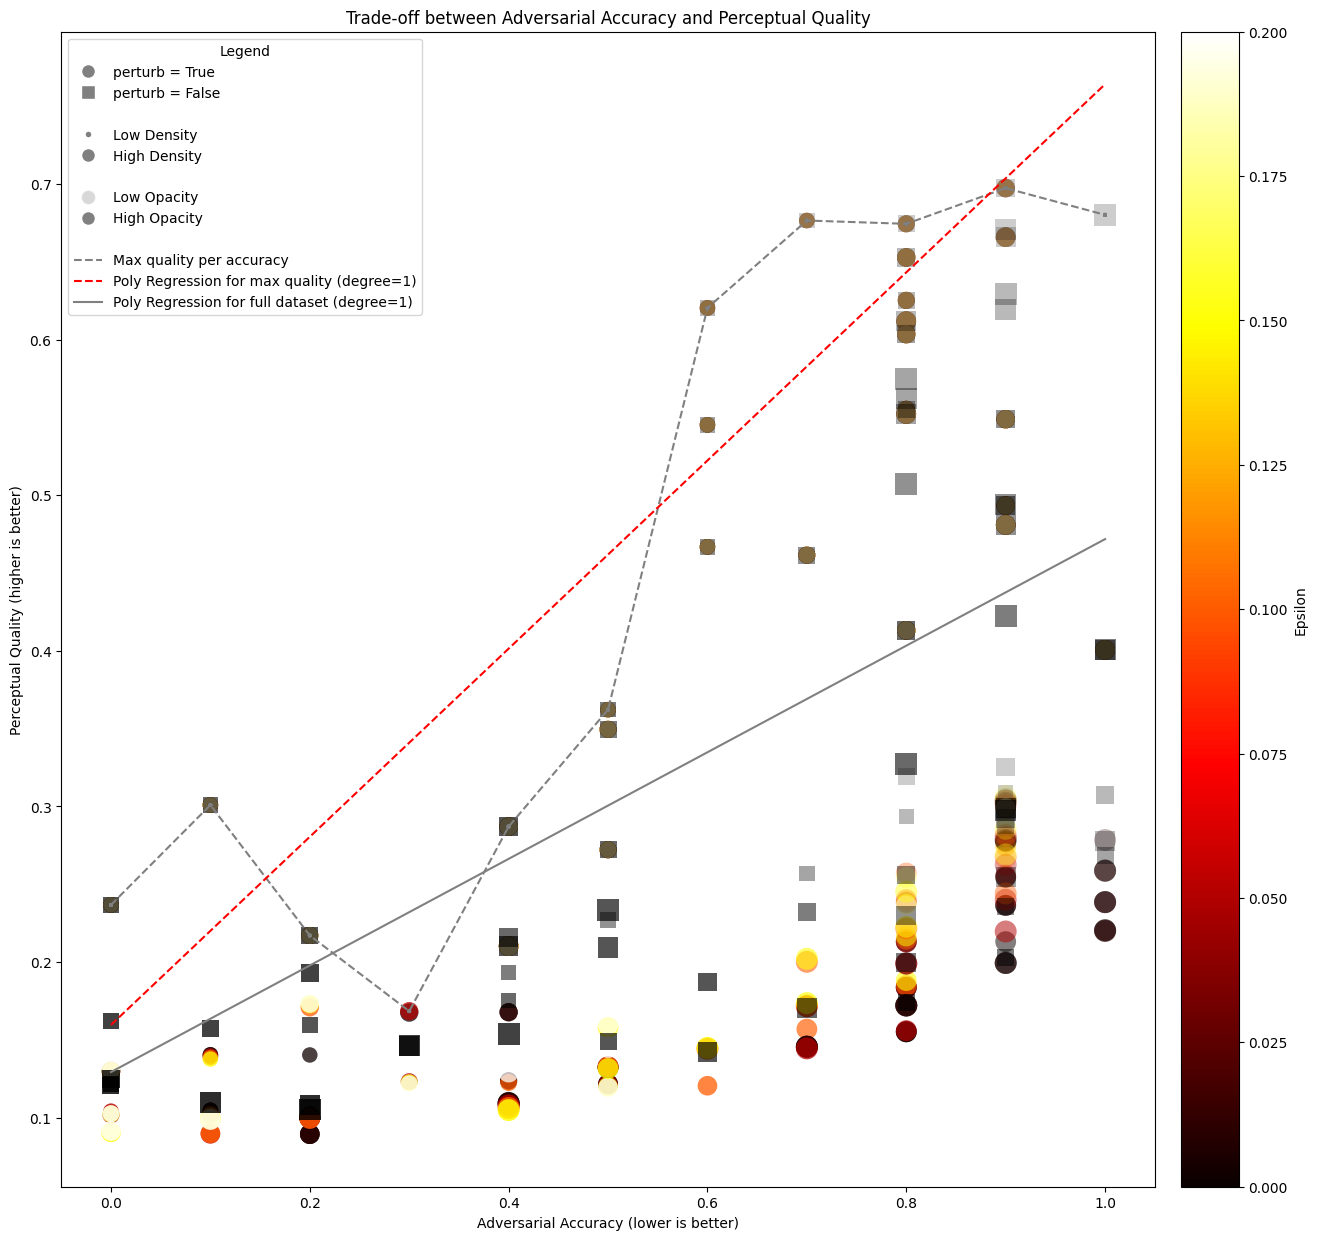

In [140]:
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
from scipy import optimize
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "2-eval_cls_perturb.csv"
data = pd.read_csv(datapath)

"""
preprocessing
"""

data = data.replace([np.inf, -np.inf], np.nan).dropna()
keys = ['opacity', 'density', 'perturb', 'epsilon', 'img_id']
data = data.drop_duplicates(subset=keys)

# difference in accuracy between adversarial and benign examples - we want the performance to decrease relative to what it initially was (lower is better)
data['adv_acc'] = ((data['advx_acc1'] + data['advx_acc5']) / 2) - ((data['x_acc1'] + data['x_acc5']) / 2) + 1
# perceptual quality, approximates human perception (higher is better)
data['quality'] = (data['cosine_sim'] + data['psnr'] / 100 + data['ssim']) / 3

# group - get mean of just the 2 inferred metrics
data = data.groupby(['opacity', 'density', 'perturb', 'epsilon']).agg({
    'adv_acc': 'mean',
    'quality': 'mean',
}).reset_index()

data = data.replace([np.inf, -np.inf], np.nan).dropna()
if np.isinf(data['adv_acc']).any() or np.isinf(data['quality']).any():
    print("\nwarning: Infinity values still present in the data")

"""
plot
"""

plt.figure(figsize=(17, 15))

adv_acc = data['adv_acc'] # x-axis
quality = data['quality'] # y-axis

opacity = data['opacity'] # "opacity": [50, 70, 90, 110, 130, 150, 170, 190, 210]
density = data['density'] # "density": [50, 60, 70, 80, 90, 100]
epsilon = data['epsilon'] # "epsilon": [0.01, 0.05, 0.1, 0.2, 0.4, 0.8] (meaningless if perturb is False)
perturb = data['perturb'] # "perturb": [True, False]

perturb_true = data[data['perturb'] == True]
perturb_false = data[data['perturb'] == False]

scatter_true = plt.scatter(perturb_true['adv_acc'], perturb_true['quality'], 
                           label='perturb = True',
                           marker='o', 
                           s=perturb_true['density'] * 2.5,
                           alpha=perturb_true['opacity']/255, 
                           c=perturb_true['epsilon'],
                           cmap='hot', 
                           edgecolors='none')

scatter_false = plt.scatter(perturb_false['adv_acc'], perturb_false['quality'], 
                            label='perturb = False',
                            marker='s', 
                            s=perturb_false['density'] * 2.5,
                            alpha=perturb_false['opacity']/255, 
                            c='black',
                            edgecolors='none')

plt.colorbar(scatter_true, label='Epsilon', pad=0.02)

"""
maxy regression line
"""

x = data['adv_acc']
y = data['quality']

# gray max-y points
max_coords = []
for x_elem in x:
    y_elem = y[x == x_elem]
    max_y = y_elem.max()
    max_coords.append((x_elem, max_y))
    plt.scatter(x_elem, max_y, marker='o', facecolors='none', edgecolors='gray', s=3)
max_coords = sorted(max_coords, key=lambda x: x[0])
max_x, max_y = zip(*max_coords)
plt.plot(max_x, max_y, color='gray', linestyle='--')

max_coords_df = []
for x_elem, y_elem in max_coords:
    max_coords_df.append(data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0])
max_coords_df = pd.DataFrame(max_coords_df)
max_coords_df = max_coords_df.drop_duplicates(subset=['opacity', 'density', 'perturb', 'epsilon']).reset_index(drop=True)
max_coords_df['final_score'] = -max_coords_df['adv_acc'] + max_coords_df['quality']

# red max-y regression line
x = np.array(max_x).reshape(-1, 1)
y = np.array(max_y)
maxy_degree = 1
polyreg = make_pipeline(PolynomialFeatures(maxy_degree), LinearRegression())
polyreg.fit(x, y)
x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)
plt.plot(x_smooth, y_smooth, color='red', linestyle='--')

# print stuff
print("\nAll above the max-y regression line:")
above = [data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0] for x_elem, y_elem in max_coords if y_elem > polyreg.predict([[x_elem]])]
above = pd.DataFrame(above)
above = above.drop_duplicates(subset=['opacity', 'density', 'perturb', 'epsilon']).reset_index(drop=True)
above['score'] = -above['adv_acc'] + above['quality']
display(HTML(above.to_html()))

max_coords_df = max_coords_df.sort_values(by='final_score', ascending=False)
print("\nMax Quality per Accuracy (sorted by final_score):")
display(HTML(max_coords_df.to_html()))

"""
polynomial regression
"""

x = data['adv_acc'].values.reshape(-1, 1)
y = data['quality'].values

total_degree = 1
polyreg = make_pipeline(PolynomialFeatures(total_degree), LinearRegression())
polyreg.fit(x, y)

x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)

plt.plot(x_smooth, y_smooth, color='gray')

"""
legend
"""

# legend for markers
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='perturb = True', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='perturb = False', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='None', color='w', label=''),
    plt.Line2D([0], [0], marker='o', color='w', label='Low Density', markerfacecolor='gray', markersize=5),
    plt.Line2D([0], [0], marker='o', color='w', label='High Density', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='None', color='w', label=''),
    # high opacity vs low opacity
    plt.Line2D([0], [0], marker='o', color='w', label='Low Opacity', markerfacecolor='gray', markersize=10, alpha=0.3),
    plt.Line2D([0], [0], marker='o', color='w', label='High Opacity', markerfacecolor='gray', markersize=10, alpha=1),
    plt.Line2D([0], [0], marker='None', color='w', label=''),
    plt.Line2D([0], [0], color='gray', linestyle='--', label=f'Max quality per accuracy'),
    plt.Line2D([0], [0], color='red', linestyle='--', label=f'Poly Regression for max quality (degree={maxy_degree})'),
    plt.Line2D([0], [0], color='gray', label=f'Poly Regression for full dataset (degree={total_degree})'),
]

plt.legend(handles=legend_elements, title='Legend', loc='upper left')

plt.xlabel('Adversarial Accuracy (lower is better)')
plt.ylabel('Perceptual Quality (higher is better)')
plt.title('Trade-off between Adversarial Accuracy and Perceptual Quality')
plt.show()


# conclusion
